# Imports

In [1]:
from tensorflow_probability import edward2 as ed
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import inferpy as inf 

/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/hom

# Constants

In [13]:
# Data dimension
D = 2
# Mixture components
K = 2
# Datapoints of each component
N1 = 100
N2 = 900
N = N1+N2

# Generate data samples

In [34]:
###### DATA SAMPLES ######
# Define two normal distribution
aux1 = inf.models.Normal(loc=tf.ones([D])*1, scale = 1)
aux2 = inf.models.Normal(loc=tf.ones([D])*10, scale = 1)
# Stack 300 samples from the first and 700 from the second
x = np.vstack([aux1.sample(N1), aux2.sample(N2)])

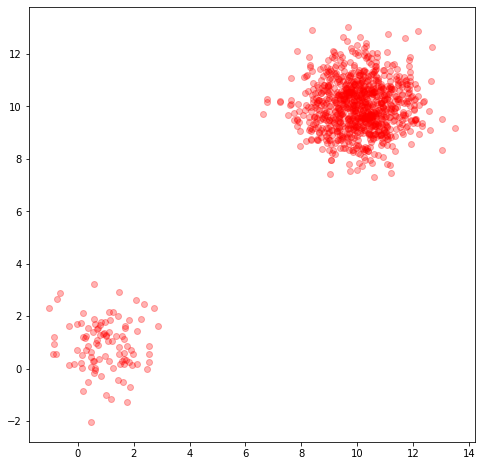

In [35]:
plt.figure(figsize=(8, 8))
plt.plot(x[:,0],x[:,1],'ro',alpha=0.3)
plt.show()

# Gaussian Mixture Model

## Parametric Model

In [52]:
# Gaussiam Mixture Model
@inf.probmodel
def gaussian_mixture(k, d, m0, b0, w0, v0):
    
    pi = inf.Dirichlet(np.ones(k)*1/k, validate_args = True, name="pi")
    
    sigma = inf.InverseGamma(
        concentration = tf.ones([k,d])*w0, 
        scale = v0, 
        name="lambda"
    )
    mu = inf.Normal(
        loc = tf.ones([k,d])*m0, 
        scale= b0*sigma,
        name="mu"
    )
        
    with inf.datamodel():
        x = inf.MixtureGaussian(locs = mu, scales = sigma, probs=pi, name="x")

m = gaussian_mixture(k = 2, d = 2, m0 = 0, b0 = 1, w0 = 1, v0 = 1)

In [53]:
m.prior().parameters()

{'pi': {'name': 'pi',
  'allow_nan_stats': True,
  'validate_args': True,
  'concentration': array([0.5, 0.5], dtype=float32)},
 'lambda': {'name': 'lambda',
  'rate': None,
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': 1,
  'concentration': array([[1., 1.],
         [1., 1.]], dtype=float32)},
 'mu': {'name': 'mu',
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': array([[88.34753  ,  1.1006682],
         [ 0.594689 ,  1.5069956]], dtype=float32),
  'loc': array([[0., 0.],
         [0., 0.]], dtype=float32)},
 'x': {'name': 'x',
  'allow_nan_stats': True,
  'validate_args': False,
  'reparameterize': False,
  'components_distribution': <tfp.distributions.Normal 'Normal_11/' batch_shape=[2, 2] event_shape=[] dtype=float32>,
  'mixture_distribution': <tfp.distributions.Categorical 'Categorical_11/' batch_shape=[] event_shape=[] dtype=int32>}}

## Variational Model

In [58]:
@inf.probmodel
def qmodel(k,d):
    qpi_param = inf.Parameter(tf.ones(k)/k, name="qpi_param")
    qpi = inf.Dirichlet(qpi_param, name="pi")
    
    qsigma_w = inf.Parameter(tf.ones([k,d]), name="qlambda_w")
    qsigma_v = inf.Parameter(tf.ones([k,d]), name="qlambda_v")
    qlambda = inf.InverseGamma(concentration = qsigma_w, scale = qsigma_v, name="lambda")
        
    qmu_m = inf.Parameter(tf.ones([k,d]), name="qmu_m")
    qmu_b = inf.Parameter(tf.ones([k,d]), name="qmu_b")
    qmu = inf.Normal(qmu_m, qmu_b, name="mu")

# Inference

In [59]:
q = qmodel(2,2)
VI = inf.inference.VI(q, epochs=1000)
m.fit({"x": x}, VI)

/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/inferpy/models/prob_model.py:187: UserWarning: Fit was called before. This will restart the inference method and                 re-build the expanded model.
  re-build the expanded model.")



 0 epochs	 18497.41796875....................
 200 epochs	 68766.15625....................
 400 epochs	 53074.42578125....................
 600 epochs	 16330.98828125....................
 800 epochs	 9049.42578125....................

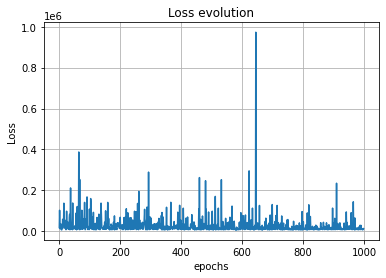

In [60]:
L = VI.losses
plt.plot(range(len(L)), L)

plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss evolution')
plt.grid(True)
plt.show()

In [61]:
m.posterior().parameters()

{'pi': {'name': 'pi',
  'allow_nan_stats': True,
  'validate_args': False,
  'concentration': array([0.67817664, 0.6809805 ], dtype=float32)},
 'lambda': {'name': 'lambda',
  'rate': None,
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': array([[1.1816294, 1.2024314],
         [1.2278491, 1.2150377]], dtype=float32),
  'concentration': array([[0.73645544, 0.6892874 ],
         [0.7081855 , 0.7150474 ]], dtype=float32)},
 'mu': {'name': 'mu',
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': array([[0.979641  , 1.0297176 ],
         [1.013893  , 0.99647284]], dtype=float32),
  'loc': array([[1.1959053, 1.2163676],
         [1.2541414, 1.242065 ]], dtype=float32)}}

In [43]:
x_gen = m.posterior_predictive('x').sample()

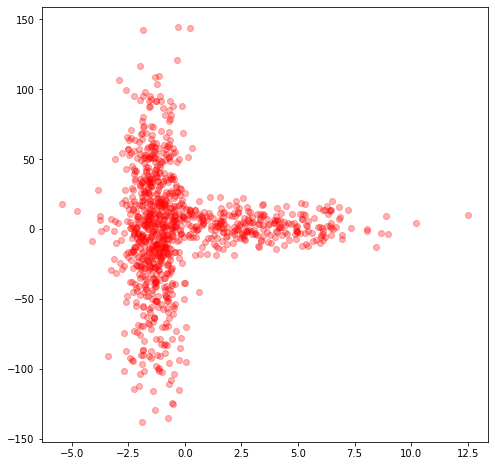

In [44]:
plt.figure(figsize=(8, 8))
plt.plot(x_gen[:,0],x_gen[:,1],'ro',alpha=0.3)
plt.show()